# Modèles experts de la couche visqueuse ($z<0.01$)

Ce problème est étudié dans la section 6.3 du rapport. 
On compare les résultats des modèles SINDy, KAN et Symbolic KAN sur un plan vertical restreint en $y=0.25$ entre $0<z<0.01$ et $0.485<x<0.515$.

In [ ]:
# import des modules
import numpy as np 
import matplotlib.pyplot as plt 
import torch 
from utils.data_processing import *
from utils.vizualisation import *
import matplotlib.colors as mcolors
from sklearn.model_selection import TimeSeriesSplit
import pysindy as ps
import kan
import torch

## Préparation des données 

Lecture des données, découpage du segment de données et ajout des conditions limites en $z=0$ : 
$$
\begin{cases}
\left. u \right|_{z=0} = 0 \\ \\
\left. w \right|_{z=0} = 0 \\ \\
\left. \theta \right|_{z=0} = 1
\end{cases}
$$

In [7]:
### parametres des données ###
n_run = 1 # numero de la run de la DNS
slicedir = 2 # direction 2 == y fixé
sliceid = 7 # slice 7 == (y=0.25)
idtime = 6080 # temps initial, ici t0 = 291.49825
ntime = 174 # nombre de points temporels
nfin = int(idtime+ntime-1) # temps final, ici tfin = 295.0015
nech=1 # pas de l'échantillonage 
nlaps = np.arange (idtime,nfin+1,nech) # les instants à récupérer
champs = ['U', 'W', 'T'] # les champs à récupérer
###############################

slices, xx, zz, tt = recup_slices(n_run, slicedir, sliceid, idtime, nlaps, champs)
print('Données récupérées : ')
print(f"    {len(tt):.0f}"+" instantanés entre "+f"{tt[0]:.3f}"+" et "+f" {tt[-1]:.3f}") 
print("    Nombre de point en x : "+f"{len(xx):.0f}")
print("    Nombre de point en z : "+f"{len(zz):.0f}")
print("\n")

### parametres des découpes ###
x_cut = [315,325] # prend plan restreint 0.485<x<0.515 et y=0.25
z_cut = 16 # prend en hauteur de 0.00 à 0.10
cond_lim = True 
###############################

X = slices[x_cut[0]:x_cut[1],:z_cut].astype(np.float32)
t = tt.astype(np.float32)
x = xx[x_cut[0]:x_cut[1]].astype(np.float32)
z = zz[:z_cut].astype(np.float32)
X.shape

if cond_lim : # conditions limites en z=0 : vitesses nulles et temperature paroi chaude (==1)
    cond_vitesses, cond_temperature = np.zeros((len(x), 1, len(t), 2)), np.ones((len(x), 1, len(t), 1))
    assemblage_cond = np.concatenate((cond_vitesses, cond_temperature), axis=3)
    X = np.concatenate((assemblage_cond, X), axis=1) # ajoute sur les données
    z = np.concatenate((np.zeros(1), z)) 
X = np.transpose(X, (2, 0, 1,  3)) # mets les dimensions d'en l'ordre

print('Données découpées : ')
print(f"    {len(t):.0f}"+" instantanés entre "+f"{t[0]:.3f}"+" et "+f" {t[-1]:.3f}") 
print("    Nombre de point en x : "+f"{len(x):.0f}")
print("    Nombre de point en z : "+f"{len(z):.0f}")
print("    Dimensions des données : "+f"{np.shape(X)}")

Données récupérées : 
    174 instantanés entre 291.498 et  295.002
    Nombre de point en x : 640
    Nombre de point en z : 832


Données découpées : 
    174 instantanés entre 291.498 et  295.001
    Nombre de point en x : 10
    Nombre de point en z : 17
    Dimensions des données : (174, 10, 17, 3)


### Création des datasets : 
- SINDy : calcule juste le label $\partial_z$ (à l'initialisation du modèle on choisira la bibliothèque de fonction qu'on normalisera)
- KAN : calcule le label $\partial_z$ et $\partial_t, \,\partial_z, \,\partial^2_z$ à mettre en entrée, puis normalise les entrées

In [19]:
### parametres des datasets ###
normalisation = True # normalise les données d'entrée
test_ratio = 0.3 # test set ratio ==30%
device = 'cpu'
###############################

# créer le label y : les dérivées verticales de u et de theta
y = np.gradient(X[:,:,:,[0,2]], z, axis=2, edge_order=2)

# calcule la derivée temporelle en entrée pour les KANs
Xt = np.gradient(X, t, axis=0, edge_order=2) 
# calcule les dérivées spatiale en x
Xx = np.gradient(X, x, axis=1, edge_order=2) 
Xxx = np.gradient(Xx, x, axis=1, edge_order=2) 

# créer la matrice d'entrée pour les KANs
X_kan = np.concatenate((X, Xt, Xx, Xxx), axis=-1)

# normalisation des données KAN, SINDy le fait dans la bibliothèque
if normalisation : 
    X_kan, mean_X_kan, std_X_kan = normalize(X_kan)

# split train/test 
tscv = TimeSeriesSplit(n_splits=2, test_size=int(t.size*test_ratio))
train_id, test_id = list(tscv.split(t))[1] 

data_kan = {}
data_kan['train_input'] = torch.tensor(X_kan[train_id].reshape(len(z)*len(train_id)*len(x), X_kan.shape[-1]), dtype=torch.float32, device=device)
data_kan['test_input'] = torch.tensor(X_kan[test_id].reshape(len(z)*len(test_id)*len(x), X_kan.shape[-1]), dtype=torch.float32, device=device)
data_kan['train_label'] = torch.tensor(y[train_id].reshape(len(z)*len(train_id)*len(x), y.shape[-1]), dtype=torch.float32, device=device)
data_kan['test_label'] = torch.tensor(y[test_id].reshape(len(z)*len(test_id)*len(x), y.shape[-1]), dtype=torch.float32, device=device)

# split SINDy
data_sindy = {}
data_sindy['train_input'] = X[train_id]
data_sindy['test_input'] = X[test_id]
data_sindy['train_label'] = y[train_id]
data_sindy['test_label'] = y[test_id]

# to split temporal vector use t[train_id], t[test_id]

print('Datasets prêts : ')
print("    Dimensions pour SINDy | input : "+f"{data_sindy['train_input'].shape}"+ "           | label : "+f"{data_sindy['train_label'].shape}")
print("    Dimensions pour KAN   | input : "+f"{data_kan['train_input'].shape}"+ "  | label : "+f"{data_kan['train_label'].shape}")



Datasets prêts : 
    Dimensions pour SINDy | input : (122, 10, 17, 3)           | label : (122, 10, 17, 2)
    Dimensions pour KAN   | input : torch.Size([20740, 12])  | label : torch.Size([20740, 2])


## SINDy
On passe à la mise en place du modèle SINDy : 
- Définir la librairie de fonction $\Psi$
- L'ajuster aux données $\Psi(u, w, \theta)$
- Entraîner le modèle avec SR3 :
$$\arg\min_{\Xi, W} \dfrac{1}{2}||\dfrac{\partial (u, \theta)}{\partial z}-\Psi(u,w,\theta)\Xi||_2^2 + \lambda ||W|| + \dfrac{\nu}{2} ||\Xi-W||_2^2$$


Les **hyperparamètres** princiaux sont : 
- $\Psi$ le choix de la librairie
- $\lambda$ le coefficient de pénalisation
- $\nu$ le coefficient de relaxation
- le nombre de **pas** d'entraînement



In [21]:
# Constuction des librairies de fonctions
library_functions = [lambda x: x]
library_function_names = [lambda x: x]

multi_ind = np.array([ # order for the derivative terms
                [1, 0], # first derivative in t
                [0, 1], # first derivative in x
                #[2, 0], # second derivative in t
                [0, 2], # second derivative in x
                ])

pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names, 
    derivative_order=1, 
    spatial_grid=t[train_id], # grille temporelle
    include_bias=True,
    include_interaction=True,
    is_uniform=False,
    implicit_terms=True, 
    temporal_grid=x, # grille pour les dérivées
    multiindices=multi_ind,
)

pde_lib_test = ps.PDELibrary( # on fait une librairie test pour ne pas donner les temps de l'ensemble de test
                              # (pour les derivées dt) à la librairie utilisée pour l'entraînement 
    library_functions=library_functions, 
    function_names=library_function_names, 
    derivative_order=1, 
    spatial_grid=t[test_id], # grille temporelle 
    include_bias=True,
    include_interaction=True,
    is_uniform=False,
    implicit_terms=True, 
    temporal_grid=x, # grille pour les dérivées
    multiindices=multi_ind,
)

data_sindy['train_transf'] = pde_lib.fit_transform(data_sindy['train_input']) # ajuste Psi aux données d'entraînement
data_sindy['test_transf'] = pde_lib_test.fit_transform(data_sindy['test_input']) # ajuste Psi aux données de test
feature_name = pde_lib.get_feature_names(input_features=champs) 
print('Construction de la librairie de fonctions :')
print("    Nombre de fonctions : "+f"{len(feature_name)}")
print("    Exemples de fonctions : "+f"{[term.replace('_t', '_x').replace('_1', '_t') for term in np.random.choice(feature_name, 3, replace=False)]}")



Construction de la librairie de fonctions :
    Nombre de fonctions : 40
    Exemples de fonctions : ['T_x', 'WW_x', 'UT_t']


In [30]:
# Entrainement avec SR3
n_iters = 90 # pas d'entrainement
opt_sindy = ps.SR3(
    threshold=70, # lambda 
    thresholder='l1', 
    normalize_columns=normalisation, # on normalise les données d'entrée Psi(u, w, theta)
    max_iter=n_iters, 
    verbose=False, 
    tol=1e-5, 
    nu=.5, # nu
)
model_sindy = ps.SINDy(
    feature_library=pde_lib, 
    optimizer=opt_sindy, 
    feature_names=champs,
)

model_sindy.fit(data_sindy['train_input'], x_dot=data_sindy['train_label'], quiet=True);

# calcule des métriques à l'aide de l'historique des coefficients Xi
metrics_sindy = {}
metrics_sindy['mae_train'], metrics_sindy['mae_test'] = [], [] # mean absolute error
metrics_sindy['mse_train'], metrics_sindy['mse_test'] = [], [] # mean squared error
metrics_sindy['complexity'] = [] # complexity == number of nonzero coefficients
for coef in model_sindy.optimizer.history_ : # calcule l'historique des scores
    metrics_sindy['complexity'].append(np.count_nonzero(coef))
    pred_train = (data_sindy['train_transf'] @ coef.T)
    pred_test = (data_sindy['test_transf'] @ coef.T)
    metrics_sindy['mae_train'].append(np.mean(np.abs(pred_train - data_sindy['train_label'])))
    metrics_sindy['mae_test'].append(np.mean(np.abs(pred_test - data_sindy['test_label'])))
    metrics_sindy['mse_train'].append(np.mean((pred_train - data_sindy['train_label'])**2))
    metrics_sindy['mse_test'].append(np.mean((pred_test - data_sindy['test_label'])**2))

# mean total of squares to compute the r2 score (here mtss for each derivative field)
mtss_train = np.mean((data_sindy['train_label'] - data_sindy['train_label'].mean(axis=(0, 1, 2)))**2, axis=(0, 1, 2))
mtss_test = np.mean((data_sindy['test_label'] - data_sindy['test_label'].mean(axis=(0, 1, 2)))**2, axis=(0, 1, 2))
# r2 score
metrics_sindy['r2_train'] = 1 - metrics_sindy['mse_train'] / mtss_train.mean()
metrics_sindy['r2_test'] = 1 - metrics_sindy['mse_test'] / mtss_test.mean()
# BIC 
n = model_sindy.optimizer.Theta_.shape[0]
metrics_sindy['bic_test'] = n * np.log(np.array(metrics_sindy['mse_test'])) + np.log(n) * np.array(metrics_sindy['complexity'])

Maintenant, on observe les performances du modèle en regardant les métriques comme le MSE, RMSE, MAE, $\text{R}^2$ et la complexité.


Pour faire une optimisation précise des hyperparamètre on peut utiliser des scores qui pénalise la complexité comme l'AIC et le BIC (plus bas, un exemple du BIC pour le choix du pas d'entraînement). 


On regarde aussi les prédictions sur le champs $(t, z)$ pour voir comment se comporte le modèle et où sont localisées les erreurs.
Niveau interprétation la complexité donne une idée mais on peut aussi extraire des équations symboliques que voici : 

In [34]:
print(r"Modèle SINDy-PDE avec SR3:")
print("     Nombre de coefficients d'apprentissage :", model_sindy.coefficients().shape)
print("     Complexité du modèle : "+f"{metrics_sindy['complexity'][-1]:.0f}")
print("     MSE score  | training : "+f"{metrics_sindy['mse_train'][-1]:.3f}", "| testing : "+f"{metrics_sindy['mse_test'][-1]:.3f}") # mse
print("     RMSE score | training :  "+f"{np.sqrt(metrics_sindy['mse_train'][-1]):.3f}", "| testing :  "+f"{np.sqrt(metrics_sindy['mse_test'][-1]):.3f}") # rmse
print("     MAE score  | training :   "+f"{metrics_sindy['mae_train'][-1]:.3f}", "| testing :  "+f"{metrics_sindy['mae_test'][-1]:.3f}") # mae
print("     R2 score   | training :   "+f"{metrics_sindy['r2_train'][-1]:.3f}", "| testing :   "+f"{metrics_sindy['r2_test'][-1]:.3f}") # r2 
print('\nEquations symboliques :')
model_sindy.print(lhs=['dU/dz','dT/dz'], precision=2)

Modèle SINDy-PDE avec SR3:
     Nombre de coefficients d'apprentissage : (2, 40)
     Complexité du modèle : 15
     MSE score  | training : 158.451 | testing : 335.876
     RMSE score | training :  12.588 | testing :  18.327
     MAE score  | training :   9.034 | testing :  13.153
     R2 score   | training :   0.674 | testing :   0.544

Equations symboliques :
dU/dz = 54.47 U + 12.04 T
dT/dz = 115.01 U + -1328.65 W + -82.66 T + -402.90 W_1 + 0.34 U_tt + 828.76 WT_1 + -1024.50 TW_1 + -123.85 UW_t + -19.40 UT_t + 79.59 WU_t + -39.39 TU_t + 4.51 TT_t + -0.59 UT_tt


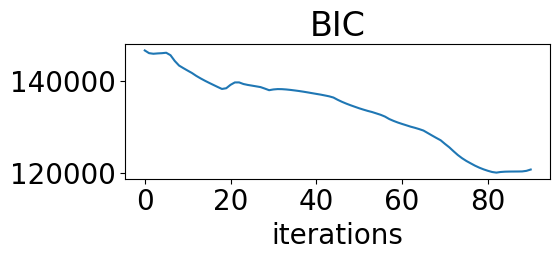

In [35]:
# plot le bic (minimisation du bic vers les 80-90 iterations)
plt.figure(figsize=(6,3))
plt.plot(metrics_sindy['bic_test'])
plt.title("BIC")
plt.xlabel("iterations")
plt.tight_layout()
plt.show()

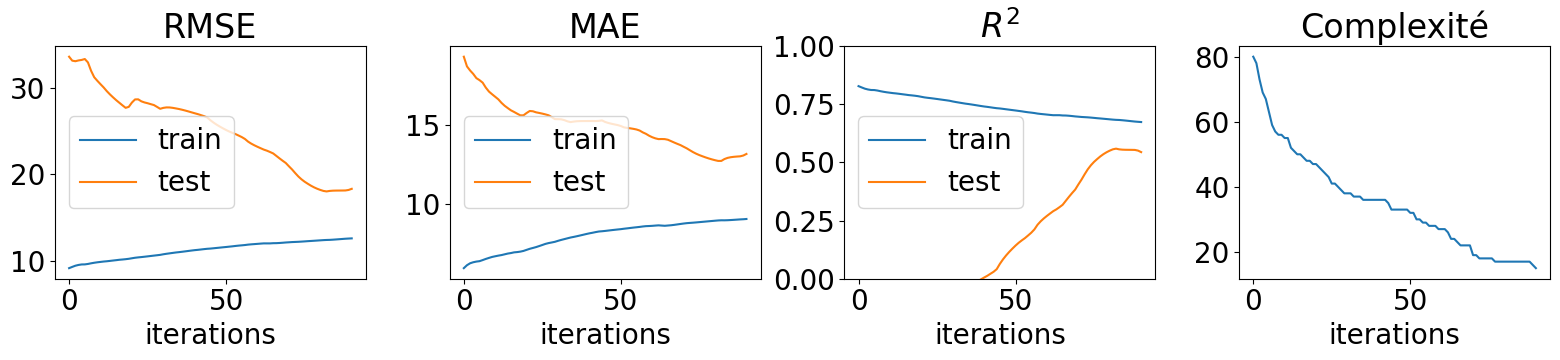

In [36]:
plot_metrics(metrics_sindy)

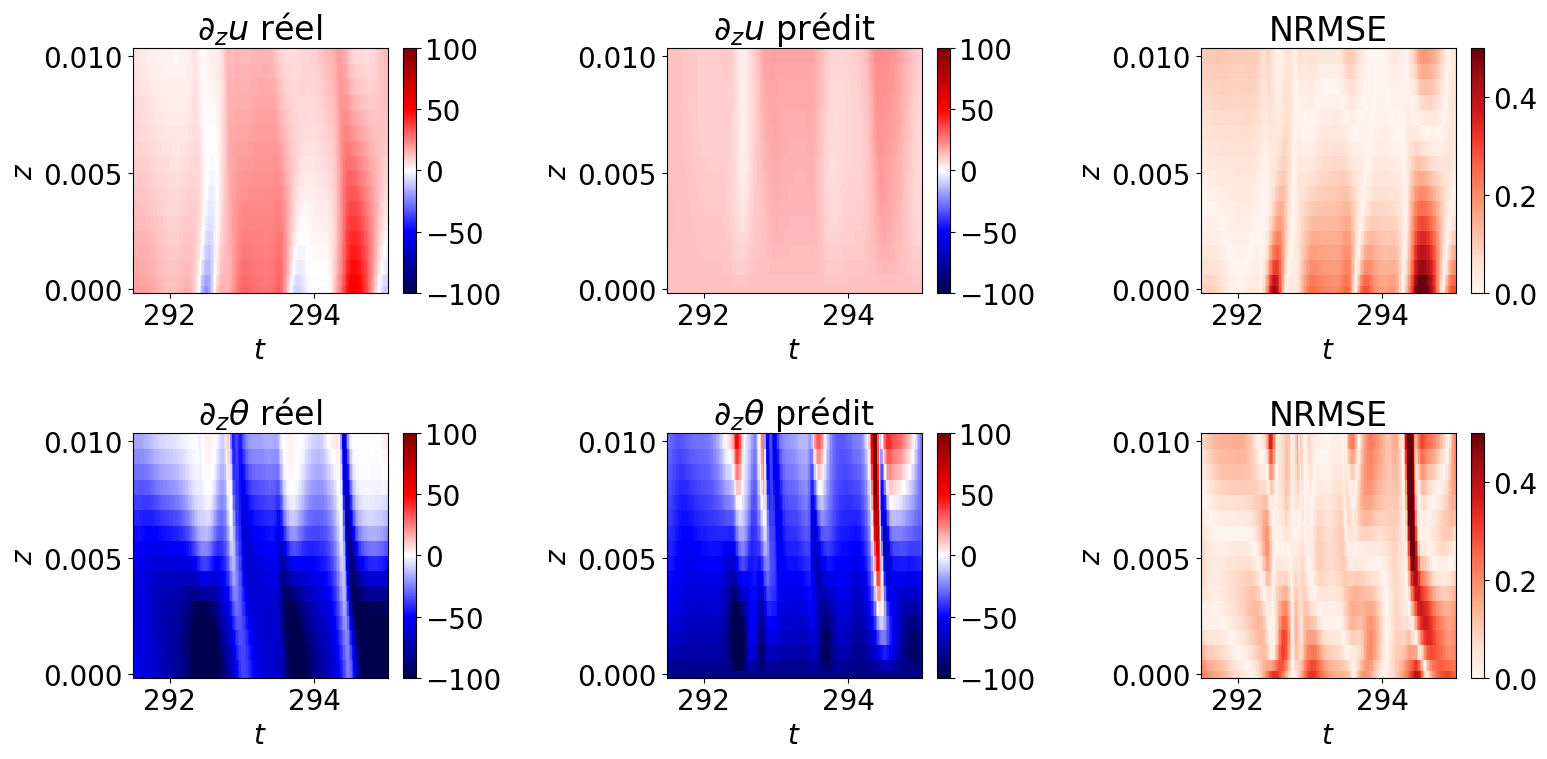

In [40]:
data_concat = np.concatenate([data_sindy['train_transf'], data_sindy['test_transf']], axis=0)
pred_concat = data_concat @ model_sindy.coefficients().T  
res_norm = mcolors.Normalize(vmin=0.0, vmax=0.5)
norm = mcolors.TwoSlopeNorm(vmin=-100.0, vcenter=0.0, vmax=100.0)
plot_results(t, z, y[:,5], pred_concat[:,5], norm=norm, res_norm=res_norm)

Comme le modèle SINDy est initialisé avec une régression non régularisée complète, les score de performances sont de suite très haut et l'objectif est de conserver le plus de possible de précision durant la régularisation parcimonieuse (qui vient faire perdre en complexité en mettant des coefficients à zéro). Sur l'ensemble test cependant les score sont très faible et s'améliore durant la régularisation, on part d'un modèle qui a surapprentis avec tous ses coefficients qu'on arrive de mieux en mieux à généraliser au fur et à mesure que l'on supprime des termes. 

On note tout de même que le modèle SINDy fait beaucoup d'erreur sur l'ensemble de test. 

In [ ]:
# testez d'autres hyperparamètres ici 

# KAN

On passe à la mise en place du modèle KAN : 
- initialiser le modèle : choix architecture et coefficient de régularisation
- entraîner le modèle avec L-BFGS (en full-batch) avec mise à jour de la grille de splines
- élaguer le modèle selon le score d'attribution (voir rapport ou [3])
- entraîner encore

=> on a un **modèle KAN élagué**

Les **hyperparamètres** princiaux sont : 
- l'architecture du modèle (couches, neurones)
- la fonction de coût et sa pénalisation
- les pas d'entraînements
- le seuil d'élagage

In [41]:
in_vars=['$u$', '$w$', r'$\theta$', 
        r'$\frac{\partial u}{\partial t}$', 
        r'$\frac{\partial w}{\partial t}$', 
        r'$\frac{\partial \theta}{\partial t}$', 
        r'$\frac{\partial u}{\partial x}$', 
        r'$\frac{\partial w}{\partial x}$', 
        r'$\frac{\partial \theta}{\partial x}$', 
        r'$\frac{\partial^2 u}{\partial x^2}$', 
        r'$\frac{\partial^2 w}{\partial x^2}$', 
        r'$\frac{\partial^2 \theta}{\partial x^2}$', ]
out_vars=[r'$\frac{\partial u}{\partial z}$', 
        r'$\frac{\partial \theta}{\partial z}$']

model_kan = kan.KAN( # initialise le modele
    width=[data_kan['train_input'].shape[-1], [5, 2], data_kan['train_label'].shape[-1]],
    grid=3, k=3, seed=1501, sparse_init=False,
)

kan_compl = [] 
steps_list = [6, 24] # les pas d'entrainement
torch.nn.functional.l1_loss.__name__='mae' # change les noms des metrics à calculer
torch.nn.functional.mse_loss.__name__='mse'

loss1 = model_kan.fit( # premier entrainement
    data_kan, 
    steps=steps_list[0], 
    loss_fn=torch.nn.MSELoss(), # fonction de coût
    update_grid = True, # met à jour la grille spline
    grid_update_num=3, # la met à jour après 3 pas
    lr = 5e-1, # learning rate
    lamb=10, # pénalisation
    opt='LBFGS', # optimiseur
    metrics=[torch.nn.functional.mse_loss, torch.nn.functional.l1_loss], # calcule la loss pour le MSE et le MAE
    log=1,
);
kan_compl.append( model_kan.n_edge )

model_kan.prune(0.5) # elagage

loss2 = model_kan.fit( # second entrainement
    data_kan, 
    steps=steps_list[1], 
    loss_fn=torch.nn.MSELoss(), # fonction de coût
    update_grid = False, # ne met pas à jour la grille spline
    lr = 5e-1, # learning rate
    lamb=0.1, # pénalisation
    opt='LBFGS', # optimiseur
    metrics=[torch.nn.functional.mse_loss, torch.nn.functional.l1_loss], # calcule la loss pour le MSE et le MAE
    log=1,
);
kan_compl.append( model_kan.n_edge )

metrics_kan = {}
for k in loss1.keys():
    metrics_kan[k] = loss1[k] + loss2[k]
metrics_kan['r2_train'] = 1 - metrics_kan['mse_train'] / mtss_train.mean()
metrics_kan['r2_test'] = 1 - metrics_kan['mse_test'] / mtss_test.mean()
metrics_kan['complexity'] = list(np.concatenate([np.ones(steps_list[0])*kan_compl[0],np.ones(steps_list[1])*kan_compl[1]]))


checkpoint directory created: ./model
saving model version 0.0


| train_loss: 9.72e+00 | test_loss: 1.73e+01 | reg: 2.18e+01 | : 100%|█| 6/6 [00:26<00:00,  4.47s/it


saving model version 0.1
saving model version 0.2


| train_loss: 7.14e+00 | test_loss: 1.52e+01 | reg: 2.90e+01 | : 100%|█| 24/24 [01:39<00:00,  4.13s/

saving model version 0.2


Modèle KAN pruned avec LBFGS:
     Nombre de branche à l'initialisation : 122.0
     Nombre de branche après l'entraînement : 26.0
     MSE score  | training : 51.026 | testing : 230.070
     RMSE score | training :  7.143 | testing :  15.168
     MAE score  | training :  4.960 | testing :  11.517
     R2 score   | training :  0.895 | testing :  0.688




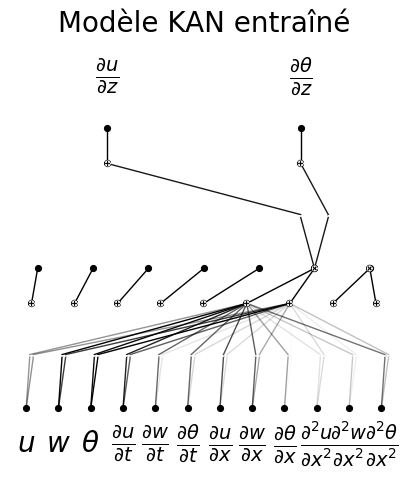

In [42]:

print(r"Modèle KAN pruned avec LBFGS:")
print("     Nombre de branche à l'initialisation :", metrics_kan['complexity'][0])
print("     Nombre de branche après l'entraînement :", metrics_kan['complexity'][-1])
print("     MSE score  | training : "+f"{metrics_kan['mse_train'][-1]:.3f}", "| testing : "+f"{metrics_kan['mse_test'][-1]:.3f}") # mse
print("     RMSE score | training :  "+f"{np.sqrt(metrics_kan['mse_train'][-1]):.3f}", "| testing :  "+f"{np.sqrt(metrics_kan['mse_test'][-1]):.3f}") # rmse    
print("     MAE score  | training :  "+f"{metrics_kan['mae_train'][-1]:.3f}", "| testing :  "+f"{metrics_kan['mae_test'][-1]:.3f}") # mae
print("     R2 score   | training :  "+f"{metrics_kan['r2_train'][-1]:.3f}", "| testing :  "+f"{metrics_kan['r2_test'][-1]:.3f}") # r2 
print('\n')

model_kan.plot(in_vars=in_vars, out_vars=out_vars, title="Modèle KAN entraîné")


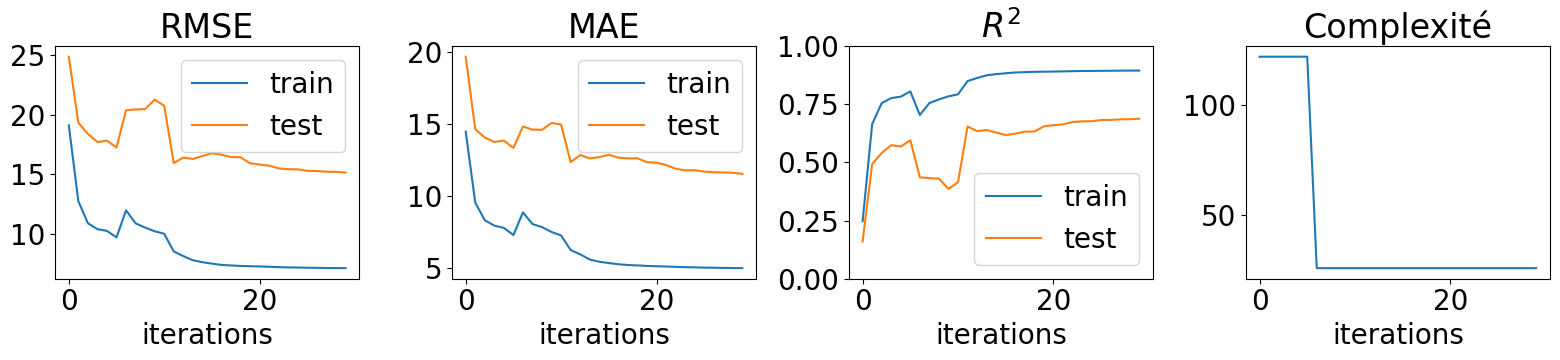

In [43]:
plot_metrics(metrics_kan)

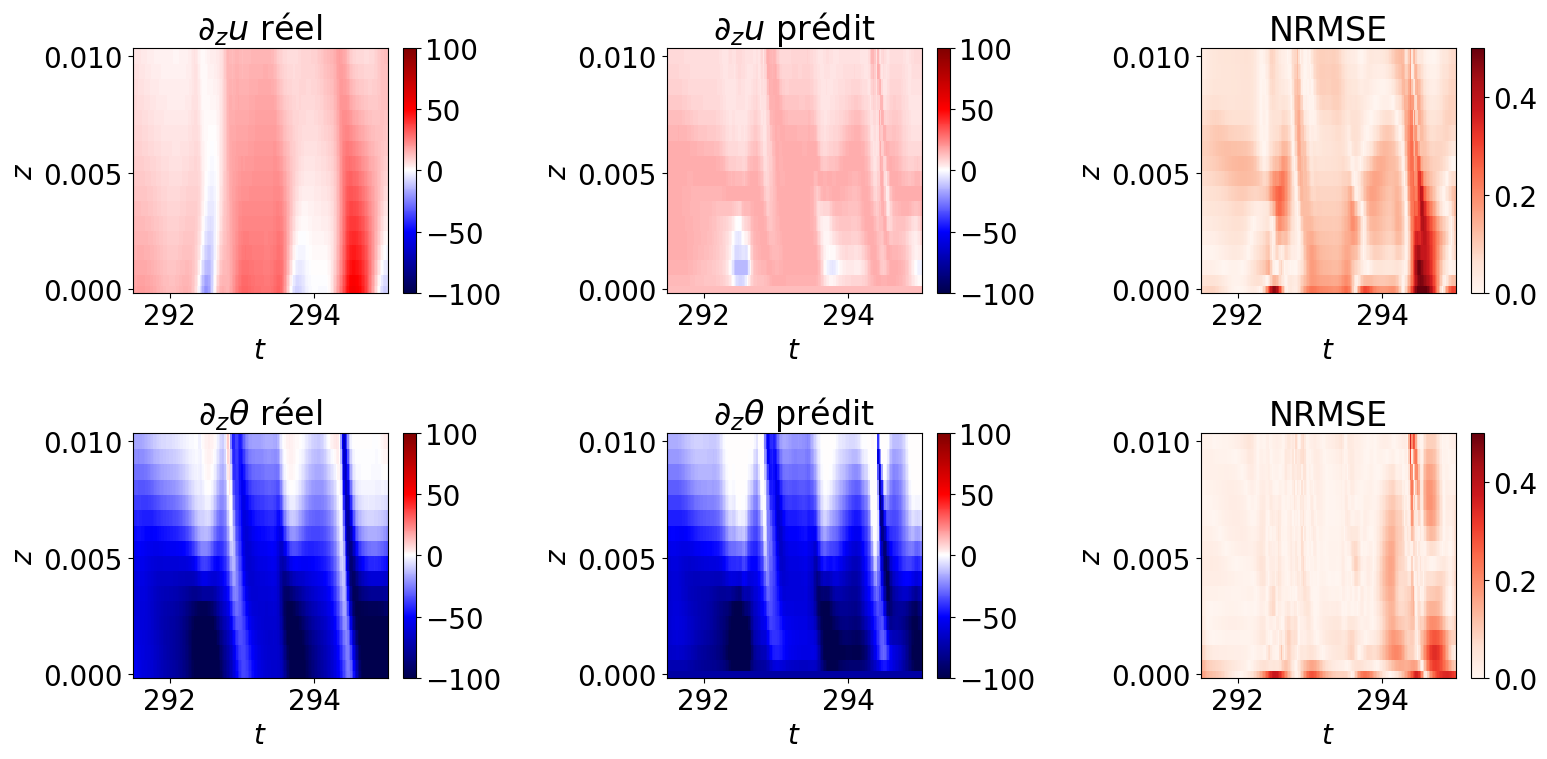

In [46]:
data_concat = torch.concatenate([data_kan['train_input'], data_kan['test_input']], axis=0)
pred_concat = model_kan(data_concat).reshape(len(t), len(x), len(z), -1).detach().numpy()
plot_results(t, z, y[:,5], pred_concat[:,5], norm=norm, res_norm=res_norm)

On observe une baisse des performances après l'élagage, mais celle ci est vite rattrappée par la suite de l'entraînement.

Enfin au niveau des prédictions, on remarque que le modèle KAN retrouve très bien la structure (surtout pour $\partial_z \theta$). Il fait beaucoup moins d'erreur que SINDy.

In [47]:
# testez d'autres hyperparamètres ici 

## Symbolic KAN

Comme l'élagage précédent permet d'obtenir un modèle KAN avec une structure simple, composé d'un unique noeud caché, on va maintenant partir de cette architecture afin de passer à un modèle symbolique. Les étapes pour la mise en place de ce modèle : 
- initialiser le modèle selon l'architecture finale de KAN précédent
- entraîner le modèle avec L-BFGS (en full-batch) avec mise à jour de la grille de splines
- convertir les splines en fonctions symboliques, si le score du $R^2>\rho$
- entraîner encore
- convertir les splines restantes en fonctions symboliques
- entraîner à nouveau

=> on a un **modèle KAN symbolique**

Les **hyperparamètres** princiaux sont :
- les pas d'entraînements
- les fonctions symboliques disponibles à la conversion
- le seuil de conversion $\rho$

In [85]:
model_skan = kan.KAN( # initialise le modele
    width=[data_kan['train_input'].shape[-1], [0, 1], data_kan['train_label'].shape[-1]],
    grid=3, k=3, seed=1501, sparse_init=False,
)

kan_compl = [] 
steps_list = [6, 12, 12] # les pas d'entrainement
torch.nn.functional.l1_loss.__name__='mae' # change les noms des metrics à calculer
torch.nn.functional.mse_loss.__name__='mse'

loss1 = model_skan.fit( # premier entrainement
    data_kan, 
    batch=-1,
    steps=steps_list[0], 
    loss_fn=torch.nn.MSELoss(), # fonction de coût
    update_grid = True, # met à jour la grille spline
    grid_update_num=3, # la met à jour après 3 pas
    lr = 5e-1, # learning rate
    lamb=10, # pénalisation
    opt='LBFGS', # optimiseur
    metrics=[torch.nn.functional.mse_loss, torch.nn.functional.l1_loss], # calcule la loss pour le MSE et le MAE
    log=1,
);
kan_compl.append( model_skan.n_edge )

# deux façons de faire : 
# l'auto symbolique puis unfix les fonctions avec le R2 sous un certain seuil
# model_skan.auto_symbolic(lib=['x', '1/x', 'x^2', 'exp', 'log']) # peut modifier les fonctions pour le passage en symbolique

# on peut choisir spécifiquement par quelle fonction remplacer la spline :
# model_skan.fix_symbolic(0, 0, 0, 'x')
#model_skan.auto_symbolic(lib=['x', 'x^2', 'exp', 'log', '1/x']);

# pour avoir comme dans le rapport :
model_skan.fix_symbolic(0, 0, 0, 'exp');
model_skan.fix_symbolic(0, 1, 0, 'x^2');
model_skan.fix_symbolic(0, 1, 1, 'x');
model_skan.fix_symbolic(0, 2, 0, 'x^2');
model_skan.fix_symbolic(0, 3, 1, 'x');
for i in [4, 5, 6, 7] :
    model_skan.fix_symbolic(0, i, 0, 'x');
    model_skan.fix_symbolic(0, i, 1, 'x');
model_skan.fix_symbolic(0, 8, 0, 'x^2');
model_skan.fix_symbolic(0, 8, 1, 'x^2');
model_skan.fix_symbolic(0, 9, 0, 'exp');
model_skan.fix_symbolic(0, 10, 1, 'x');
model_skan.fix_symbolic(1, 0, 0, 'x');
model_skan.fix_symbolic(1, 0, 1, 'x');


checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.23e+01 | test_loss: 2.07e+01 | reg: 1.27e+01 | : 100%|█| 6/6 [00:09<00:00,  1.52s/it


saving model version 0.1
r2 is 0.8968988656997681
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.2
Best value at boundary.
r2 is 0.9756589531898499
saving model version 0.3
Best value at boundary.
r2 is 0.8463791608810425
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.4
r2 is 0.9865692853927612
saving model version 0.5
r2 is 0.1962856650352478
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.6
r2 is 0.45554736256599426
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.7
r2 is 0.4707728922367096
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.8
r2 is 0.5382881760597229
r2 is not very high, please double check if you are choosing the correct symbolic function.

In [96]:
# erreur avec la dernière conversion symbolique
model_skan = model_skan.rewind('0.19') # on recharge le modèle précendent

loss2 = model_skan.fit( # un pas d'entrainement
    data_kan, 
    batch=-1,
    steps=1, 
    loss_fn=torch.nn.MSELoss(), # fonction de coût
    update_grid = False, # ne met pas à jour la grille spline
    lr = 5e1, # learning rate
    lamb=.1, # pénalisation
    opt='LBFGS', # optimiseur
    metrics=[torch.nn.functional.mse_loss, torch.nn.functional.l1_loss], # calcule la loss pour le MSE et le MAE
    log=1,
);

model_skan.fix_symbolic(1, 0, 1, 'x'); # continue la conversion symbolique

# on pourrait après chaque conversion faire un pas d'entrainement pour prevenir les problèmes

rewind to model version 1.19, renamed as 2.19


| train_loss: 1.52e+01 | test_loss: 2.17e+01 | reg: 7.16e+00 | : 100%|█| 1/1 [00:02<00:00,  2.06s/it


saving model version 1.20
r2 is 0.4896531105041504
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 1.21


In [97]:
# unfix if R2<0.30

loss2 = model_skan.fit( # second entrainement
    data_kan, 
    batch=-1,
    steps=steps_list[1], 
    loss_fn=torch.nn.MSELoss(), # fonction de coût
    update_grid = False, # ne met pas à jour la grille spline
    lr = 5e1, # learning rate
    lamb=.1, # pénalisation
    opt='LBFGS', # optimiseur
    metrics=[torch.nn.functional.mse_loss, torch.nn.functional.l1_loss], # calcule la loss pour le MSE et le MAE
    log=1,
);

kan_compl.append( model_skan.n_edge )
#model_skan.auto_symbolic(lib=['x', '1/x', 'x^2', 'exp', 'log']); # peut modifier les fonctions pour le passage en symbolique
model_skan.fix_symbolic(0, 0, 1, 'x^2');
model_skan.fix_symbolic(0, 2, 1, 'x');
model_skan.fix_symbolic(0, 3, 0, 'x');
model_skan.fix_symbolic(0, 9, 1, 'x^2');
model_skan.fix_symbolic(0, 10, 0, 'x');
model_skan.fix_symbolic(0, 11, 0, 'x');
model_skan.fix_symbolic(0, 11, 1, 'x');

| train_loss: 1.17e+01 | test_loss: 1.96e+01 | reg: 1.10e+00 | : 100%|█| 12/12 [00:24<00:00,  2.00s/


saving model version 1.22
r2 is 0.9935396909713745
saving model version 1.23
r2 is 0.4556489884853363
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 1.24
Best value at boundary.
r2 is 0.35280337929725647
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 1.25
r2 is 0.9883515238761902
saving model version 1.26
Best value at boundary.
r2 is 0.8762006163597107
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 1.27
r2 is 0.5129380822181702
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 1.28
r2 is 0.2639380395412445
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 1.29


In [98]:

loss3 = model_skan.fit( # second entrainement
    data_kan, 
    batch=-1,
    steps=steps_list[2], 
    loss_fn=torch.nn.MSELoss(), # fonction de coût
    update_grid = False, # ne met pas à jour la grille spline
    lr = 5e-2, # learning rate
    lamb=0.1, # pénalisation
    opt='LBFGS', # optimiseur
    metrics=[torch.nn.functional.mse_loss, torch.nn.functional.l1_loss], # calcule la loss pour le MSE et le MAE
    log=1,
);

kan_compl.append( model_skan.n_edge )

metrics_skan = {}
for k in loss1.keys():
    metrics_skan[k] = loss1[k] + loss2[k] + loss3[k]
metrics_skan['r2_train'] = 1 - metrics_skan['mse_train'] / mtss_train.mean()
metrics_skan['r2_test'] = 1 - metrics_skan['mse_test'] / mtss_test.mean()
metrics_skan['complexity'] = list(np.concatenate([np.ones(steps_list[0])*kan_compl[0],np.ones(steps_list[1])*kan_compl[1],np.ones(steps_list[2])*kan_compl[2]]))

| train_loss: 1.11e+01 | test_loss: 1.76e+01 | reg: 0.00e+00 | : 100%|█| 12/12 [00:24<00:00,  2.00s/

saving model version 1.30


Modèle KAN symbolique avec L-BFGS:
     Nombre de branche à l'initialisation : 26.0
     Nombre de branche après l'entraînement : 7.0
     MSE score  | training : 123.599 | testing : 310.185
     RMSE score | training :  11.118 | testing :  17.612
     MAE score  | training :  7.890 | testing :  13.181
     R2 score   | training :  0.745 | testing :  0.579




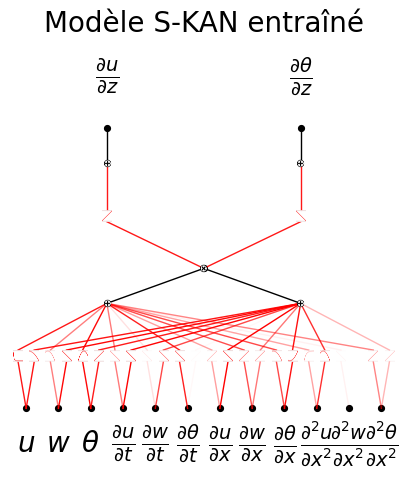

In [99]:

print(r"Modèle KAN symbolique avec L-BFGS:")
print("     Nombre de branche à l'initialisation :", metrics_skan['complexity'][0])
print("     Nombre de branche après l'entraînement :", metrics_skan['complexity'][-1])
print("     MSE score  | training : "+f"{metrics_skan['mse_train'][-1]:.3f}", "| testing : "+f"{metrics_skan['mse_test'][-1]:.3f}") # mse
print("     RMSE score | training :  "+f"{np.sqrt(metrics_skan['mse_train'][-1]):.3f}", "| testing :  "+f"{np.sqrt(metrics_skan['mse_test'][-1]):.3f}") # rmse    
print("     MAE score  | training :  "+f"{metrics_skan['mae_train'][-1]:.3f}", "| testing :  "+f"{metrics_skan['mae_test'][-1]:.3f}") # mae
print("     R2 score   | training :  "+f"{metrics_skan['r2_train'][-1]:.3f}", "| testing :  "+f"{metrics_skan['r2_test'][-1]:.3f}") # r2 
print('\n')

model_skan.plot(in_vars=in_vars, out_vars=out_vars, title="Modèle S-KAN entraîné")


Maintenant, on observe les performances du modèle en regardant les métriques comme le MSE, RMSE, MAE, $\text{R}^2$ et la complexité.

On regarde aussi les prédictions sur le champs $(t, z)$ pour voir comment se comporte le modèle et où sont localisées les erreurs.
Niveau interprétation la complexité est ici le nombre de branches splines actives, comme on passe à des splines symboliques ça tombe à zéro, mais cette fois-ci on extrait des équations symboliques.

In [100]:
print("du/dz =",kan.ex_round(model_skan.symbolic_formula()[0][0], 2))
print("dT/dz =",kan.ex_round(model_skan.symbolic_formula()[0][1], 2))

du/dz = 0.01*(0.02*x_12 - 0.18*x_2 + 0.13*x_3 - 0.18*x_4 - 0.09*x_5 - 0.3*x_7 + 0.06*x_8 - 0.05*(-0.71*x_1 - 1)**2 - 0.1*(-0.59*x_10 - 1)**2 + 0.09*(-0.42*x_9 - 1)**2 + 1.37)*(-0.14*x_11 + 0.67*x_12 - 0.75*x_4 - 0.21*x_5 - 1.6*x_6 + 0.52*x_7 + 1.56*x_8 - 3.41*(0.46 - x_3)**2 - 0.36*(-0.78*x_2 - 1)**2 - 1.13*(-0.34*x_9 - 1)**2 + 2.37 - 0.29*exp(-0.84*x_10) + 0.36*exp(-3.04*x_1)) + 12.13
dT/dz = -5.04*(0.02*x_12 - 0.18*x_2 + 0.13*x_3 - 0.18*x_4 - 0.09*x_5 - 0.3*x_7 + 0.06*x_8 - 0.05*(-0.71*x_1 - 1)**2 - 0.1*(-0.59*x_10 - 1)**2 + 0.09*(-0.42*x_9 - 1)**2 + 1.37)*(-0.14*x_11 + 0.67*x_12 - 0.75*x_4 - 0.21*x_5 - 1.6*x_6 + 0.52*x_7 + 1.56*x_8 - 3.41*(0.46 - x_3)**2 - 0.36*(-0.78*x_2 - 1)**2 - 1.13*(-0.34*x_9 - 1)**2 + 2.37 - 0.29*exp(-0.84*x_10) + 0.36*exp(-3.04*x_1)) - 56.7


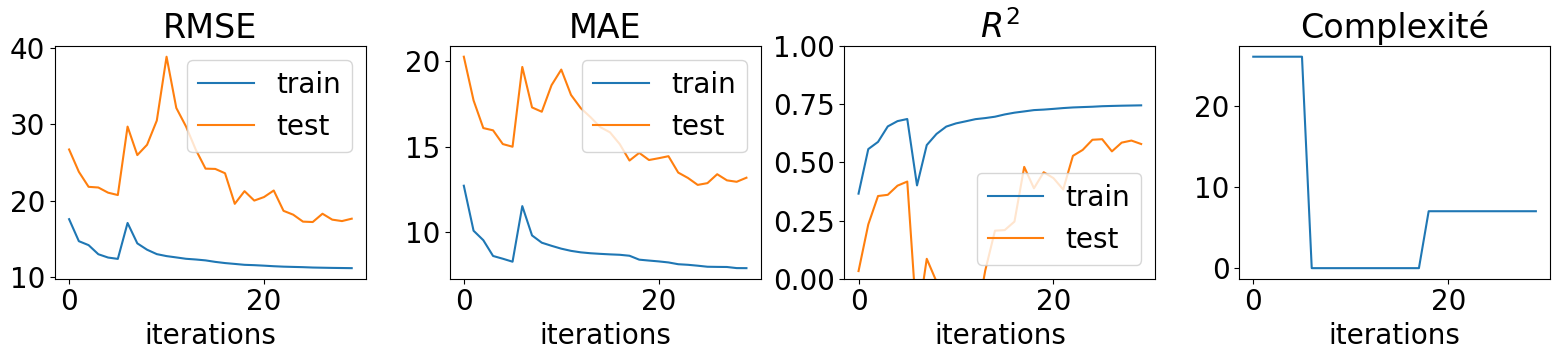

In [101]:
plot_metrics(metrics_skan)

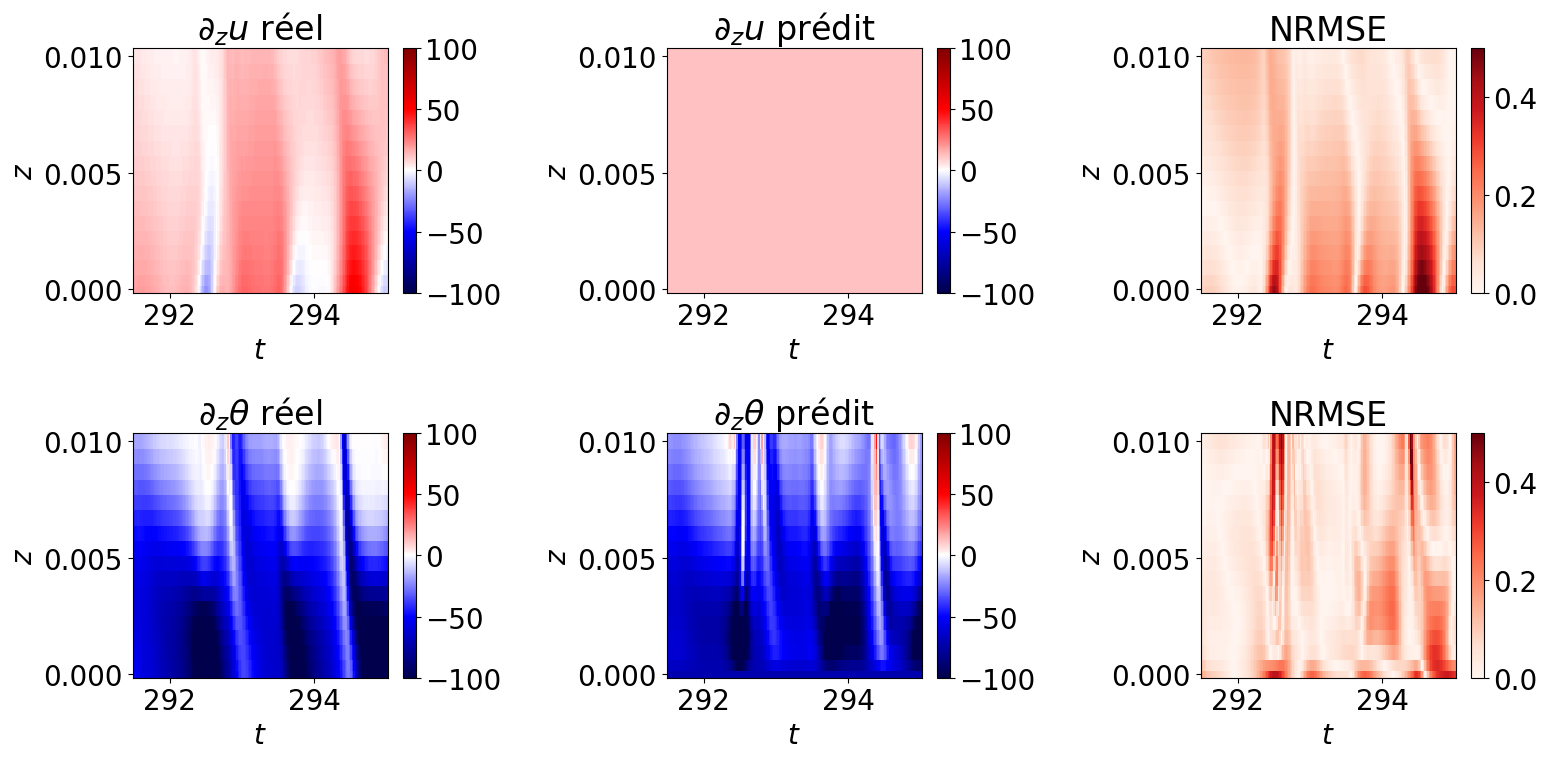

In [102]:
data_concat = torch.concatenate([data_kan['train_input'], data_kan['test_input']], axis=0)
pred_concat = model_skan(data_concat).reshape(len(t), len(x), len(z), -1).detach().numpy()
plot_results(t, z, y[:,5], pred_concat[:,5], norm=norm, res_norm=res_norm)

In [ ]:
# testez d'autres hyperparamètres ici 

## Synthèse des résultats

Cette fois-ci on a clairement une différence signififcative entre les performances des KANs et de SINDy qui est moins précis. 
Mais SINDy reste plus interprétable que les deux autres, Symbolic-KAN est un bon compromis entre interprétabilité et précision qui permet d'extraire des équations symboliques.

Globalement, c'était une bonne idée de spécialiser les modèles sur la couche visqueuse, on arrive a bien améliorer les performances sur dans cette zone. On remarque aussi un déséquilibre entre les estimations de $\partial_z u$ et de $\partial_z \theta$, aussi bien côté performance pour Symbolic KAN que côté complexité des équation pour SINDy. C'est dû au fait que les gradients sont plus intense pour $\partial_z \theta$, les modèles délaissent donc $\partial_z u$ puisqu'il y a moins d'erreur à faire de ce coté.

Les idées à essayer pour améliorer les estimations de nos dérivées spatiales : 
- faire des modèles différents pour $\partial_z u$ et $\partial_z \theta$ ou bien customiser la fonction de coût
- assembler des modèles experts de la couche visqueuse avec des modèles experts de l'écoulement externe pour avoir de meilleurs performances sur le plan restreint $0<z<0.10$
- ajouter plus de données en $x$
- essayer en dégrandant les données proches paroi
- essayer avec les KANs de prédire la paroi à partir de données au-dessus 